In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_paths = []
labels = []

root_path = '/content/drive/MyDrive/fire_dataset'

for subfolder in os.listdir(root_path):
    subfolder_path = os.path.join(root_path, subfolder)
    if os.path.isdir(subfolder_path):
        label = subfolder  # Sử dụng tên thư mục làm label
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(subfolder_path, image_filename)
                image_paths.append(image_path)
                labels.append(label)

# Tạo DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

print(df.head())

                                          image_path            label
0  /content/drive/MyDrive/fire_dataset/non_fire_i...  non_fire_images
1  /content/drive/MyDrive/fire_dataset/non_fire_i...  non_fire_images
2  /content/drive/MyDrive/fire_dataset/non_fire_i...  non_fire_images
3  /content/drive/MyDrive/fire_dataset/non_fire_i...  non_fire_images
4  /content/drive/MyDrive/fire_dataset/non_fire_i...  non_fire_images


In [ ]:
df

,image_path,label
0,/content/drive/MyDrive/fire_dataset/non_fire_i...,non_fire_images
1,/content/drive/MyDrive/fire_dataset/non_fire_i...,non_fire_images
2,/content/drive/MyDrive/fire_dataset/non_fire_i...,non_fire_images
3,/content/drive/MyDrive/fire_dataset/non_fire_i...,non_fire_images
4,/content/drive/MyDrive/fire_dataset/non_fire_i...,non_fire_images
...,...,...
994,/content/drive/MyDrive/fire_dataset/fire_image...,fire_images
995,/content/drive/MyDrive/fire_dataset/fire_image...,fire_images
996,/content/drive/MyDrive/fire_dataset/fire_image...,fire_images
997,/content/drive/MyDrive/fire_dataset/fire_image...,fire_images


In [ ]:
df['label'] = df['label'].map({'fire_images': 0, 'non_fire_images': 1})
df

,image_path,label
0,/content/drive/MyDrive/fire_dataset/non_fire_i...,1
1,/content/drive/MyDrive/fire_dataset/non_fire_i...,1
2,/content/drive/MyDrive/fire_dataset/non_fire_i...,1
3,/content/drive/MyDrive/fire_dataset/non_fire_i...,1
4,/content/drive/MyDrive/fire_dataset/non_fire_i...,1
...,...,...
994,/content/drive/MyDrive/fire_dataset/fire_image...,0
995,/content/drive/MyDrive/fire_dataset/fire_image...,0
996,/content/drive/MyDrive/fire_dataset/fire_image...,0
997,/content/drive/MyDrive/fire_dataset/fire_image...,0


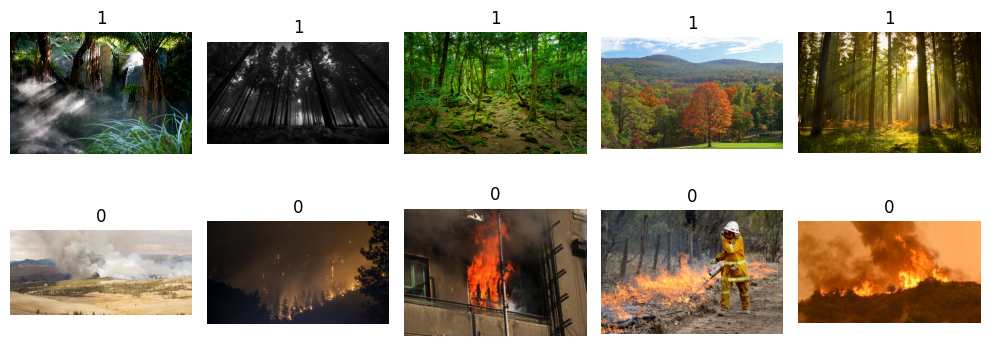

In [ ]:
#Hiển thị 5 ảnh mỗi lớp
import matplotlib.pyplot as plt
from PIL import Image

# Số ảnh muốn hiển thị mỗi lớp
samples_per_class = 5

# Lấy danh sách nhãn
class_labels = df['label'].unique()

# Tạo figure
plt.figure(figsize=(samples_per_class * 2, len(class_labels) * 2))

# Duyệt qua từng lớp
for i, label in enumerate(class_labels):
    # Lấy `samples_per_class` ảnh thuộc lớp này
    subset = df[df['label'] == label].sample(samples_per_class, random_state=42)

    for j, row in enumerate(subset.itertuples()):
        img = Image.open(row.image_path)
        plt.subplot(len(class_labels), samples_per_class, i * samples_per_class + j + 1)
        plt.imshow(img)
        plt.title(str(label))
        plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from torch.utils.data import Dataset
import cv2
import torch
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)


train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['label'])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# Create datasets
train_dataset = CustomDataset(train_df, transform=transform)
val_dataset = CustomDataset(val_df, transform=transform)
test_dataset = CustomDataset(test_df, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torchvision.models as models
class AlzheimerResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(AlzheimerResNet18, self).__init__()

        self.backbone = models.resnet18(pretrained=False)

        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model = AlzheimerResNet18(num_classes=2)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.000125)
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlzheimerResNet18(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from tqdm import tqdm
import numpy as np

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device).float(), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total
        train_loss = running_loss / len(train_loader)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_running_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).float(), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_acc = val_correct / val_total
        val_loss = val_running_loss / len(val_loader)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

    # Plot metrics
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss per Epoch")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix on Validation Set")
    plt.show()


Epoch 1/30: 100%|██████████| 25/25 [04:44<00:00, 11.37s/it]


Epoch [1/30], Train Loss: 0.2948, Train Acc: 0.8598, Val Loss: 0.4538, Val Acc: 0.7600


Epoch 2/30: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


Epoch [2/30], Train Loss: 0.1452, Train Acc: 0.9387, Val Loss: 0.1339, Val Acc: 0.9500


Epoch 3/30: 100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


Epoch [3/30], Train Loss: 0.1281, Train Acc: 0.9537, Val Loss: 0.0553, Val Acc: 0.9700


Epoch 4/30: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


Epoch [4/30], Train Loss: 0.0843, Train Acc: 0.9675, Val Loss: 0.1311, Val Acc: 0.9700


Epoch 5/30: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


Epoch [5/30], Train Loss: 0.0503, Train Acc: 0.9837, Val Loss: 0.0422, Val Acc: 0.9700


Epoch 6/30: 100%|██████████| 25/25 [00:25<00:00,  1.04s/it]


Epoch [6/30], Train Loss: 0.0610, Train Acc: 0.9787, Val Loss: 0.0430, Val Acc: 0.9800


Epoch 7/30: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


Epoch [7/30], Train Loss: 0.0475, Train Acc: 0.9825, Val Loss: 0.4643, Val Acc: 0.8900


Epoch 8/30: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


Epoch [8/30], Train Loss: 0.0167, Train Acc: 0.9975, Val Loss: 0.0455, Val Acc: 0.9900


Epoch 9/30: 100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


Epoch [9/30], Train Loss: 0.0062, Train Acc: 1.0000, Val Loss: 0.0895, Val Acc: 0.9700


Epoch 10/30: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


Epoch [10/30], Train Loss: 0.0045, Train Acc: 0.9987, Val Loss: 0.0444, Val Acc: 0.9900


Epoch 11/30: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


Epoch [11/30], Train Loss: 0.0035, Train Acc: 1.0000, Val Loss: 0.0460, Val Acc: 0.9900


Epoch 12/30: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


Epoch [12/30], Train Loss: 0.0026, Train Acc: 1.0000, Val Loss: 0.0515, Val Acc: 0.9800


Epoch 13/30: 100%|██████████| 25/25 [00:25<00:00,  1.02s/it]


Epoch [13/30], Train Loss: 0.0017, Train Acc: 1.0000, Val Loss: 0.0400, Val Acc: 0.9600


Epoch 14/30: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


Epoch [14/30], Train Loss: 0.0011, Train Acc: 1.0000, Val Loss: 0.0248, Val Acc: 0.9900


Epoch 15/30: 100%|██████████| 25/25 [00:25<00:00,  1.04s/it]


Epoch [15/30], Train Loss: 0.0004, Train Acc: 1.0000, Val Loss: 0.0261, Val Acc: 0.9900


Epoch 16/30: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


Epoch [16/30], Train Loss: 0.0008, Train Acc: 1.0000, Val Loss: 0.0359, Val Acc: 0.9700


Epoch 17/30: 100%|██████████| 25/25 [00:26<00:00,  1.04s/it]


Epoch [17/30], Train Loss: 0.0022, Train Acc: 1.0000, Val Loss: 0.1024, Val Acc: 0.9700


Epoch 18/30: 100%|██████████| 25/25 [00:25<00:00,  1.04s/it]


Epoch [18/30], Train Loss: 0.0013, Train Acc: 1.0000, Val Loss: 0.0571, Val Acc: 0.9700


Epoch 19/30: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


Epoch [19/30], Train Loss: 0.0040, Train Acc: 1.0000, Val Loss: 0.0976, Val Acc: 0.9700


Epoch 20/30: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


Epoch [20/30], Train Loss: 0.0272, Train Acc: 0.9925, Val Loss: 0.3668, Val Acc: 0.8300


Epoch 21/30: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


Epoch [21/30], Train Loss: 0.1016, Train Acc: 0.9637, Val Loss: 0.1277, Val Acc: 0.9100


Epoch 22/30: 100%|██████████| 25/25 [00:25<00:00,  1.02s/it]


Epoch [22/30], Train Loss: 0.0532, Train Acc: 0.9837, Val Loss: 0.5982, Val Acc: 0.8700


Epoch 23/30: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


Epoch [23/30], Train Loss: 0.0290, Train Acc: 0.9912, Val Loss: 0.0078, Val Acc: 1.0000


Epoch 24/30: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


Epoch [24/30], Train Loss: 0.0211, Train Acc: 0.9937, Val Loss: 0.0685, Val Acc: 0.9900


Epoch 25/30: 100%|██████████| 25/25 [00:26<00:00,  1.04s/it]


Epoch [25/30], Train Loss: 0.0134, Train Acc: 0.9962, Val Loss: 0.0110, Val Acc: 1.0000


Epoch 26/30: 100%|██████████| 25/25 [00:26<00:00,  1.04s/it]


Epoch [26/30], Train Loss: 0.0067, Train Acc: 1.0000, Val Loss: 0.0488, Val Acc: 0.9700


Epoch 27/30: 100%|██████████| 25/25 [00:25<00:00,  1.02s/it]


Epoch [27/30], Train Loss: 0.0015, Train Acc: 1.0000, Val Loss: 0.0139, Val Acc: 1.0000


Epoch 28/30: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


Epoch [28/30], Train Loss: 0.0012, Train Acc: 1.0000, Val Loss: 0.0153, Val Acc: 0.9900


Epoch 29/30: 100%|██████████| 25/25 [00:25<00:00,  1.04s/it]


Epoch [29/30], Train Loss: 0.0014, Train Acc: 1.0000, Val Loss: 0.0111, Val Acc: 1.0000


Epoch 30/30: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


Epoch [30/30], Train Loss: 0.0017, Train Acc: 1.0000, Val Loss: 0.0344, Val Acc: 0.9900


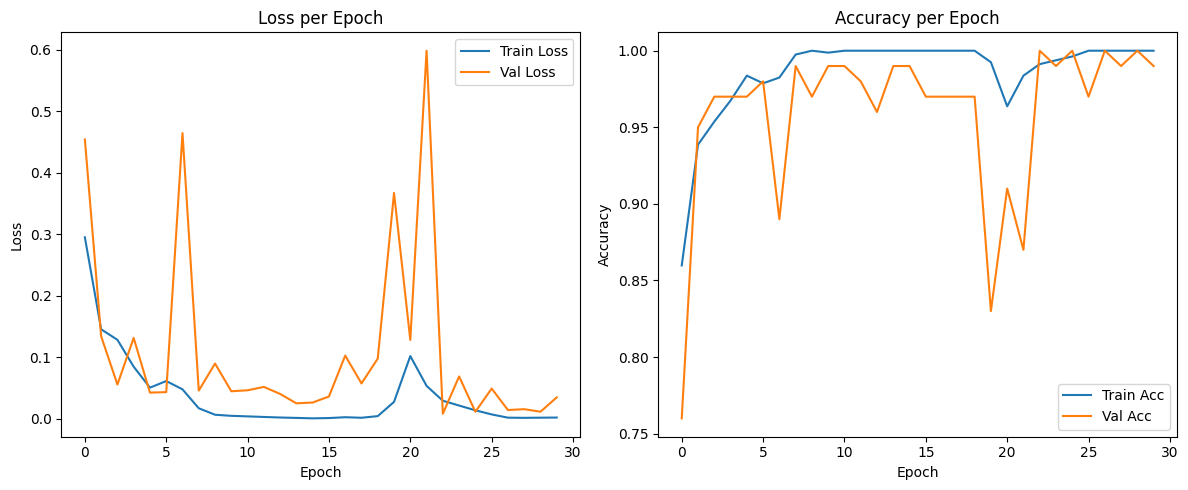

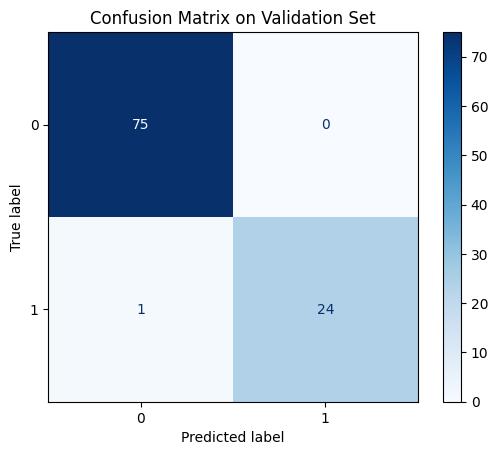

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=[0, 1], target_names=['0', '1']))



Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        76
           1       0.91      0.83      0.87        24

    accuracy                           0.94       100
   macro avg       0.93      0.90      0.92       100
weighted avg       0.94      0.94      0.94       100

